In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
BASE_PATH = "/content/gdrive/MyDrive/twitter_data/"

Mounted at /content/gdrive


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk(BASE_PATH):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/content/gdrive/MyDrive/twitter_data/twitter_validation.csv
/content/gdrive/MyDrive/twitter_data/twitter_training.csv


In [4]:
# Perform EDA on the given data
# Visualize to get a better undersanding
# Train models using transformers

## <b><span style='color:#F1A425'>Import Library</span></b>


In [5]:
!pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 361.8/361.8 kB 7.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for emoji: filename=emoji-2.7.0-py2.py3-none-any.whl size=356563 sha256=e1e92f65df57d21e1d0451644a55deb00d98f682accadcb107fe1f4b7b0f5d6b
  Stored in directory: /root/.cache/pip/wheels/41/11/48/5df0b9727d5669c9174a141134f10304d1d78a3b89a4676f3d
Successfully built emoji


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import regex as re
import emoji
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
import random
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn import preprocessing
import multiprocessing
from tqdm import tqdm

#evaluation metrics
from sklearn.metrics import confusion_matrix,f1_score,accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from yellowbrick.classifier import PrecisionRecallCurve

In [7]:
column_names = ['Tweet_ID','Entity','Sentiment','Tweet_content']
train = pd.read_csv('{}/twitter_training.csv'.format(BASE_PATH),header=None, names = column_names)
validation = pd.read_csv('{}/twitter_validation.csv'.format(BASE_PATH),header=None, names = column_names)


## <b><span style='color:#F1A425'>EDA on Data</span></b>


#### How data looks

In [8]:
# see the columns in the loaded data
train.keys()

Index(['Tweet_ID', 'Entity', 'Sentiment', 'Tweet_content'], dtype='object')

In [9]:
train.shape

(74682, 4)

In [10]:
# printing top 5
train.head(5)

,Tweet_ID,Entity,Sentiment,Tweet_content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


#### <b><span style='color:#F1A425'>Removing null values</span></b>


In [11]:
# finding null values in both training and validation data
train.isnull().sum()

Tweet_ID           0
Entity             0
Sentiment          0
Tweet_content    686
dtype: int64

In [12]:
validation.isnull().sum()

Tweet_ID         0
Entity           0
Sentiment        0
Tweet_content    0
dtype: int64

In [13]:
train.dropna(subset=['Tweet_content'], inplace=True)

In [14]:
train.isnull().sum()

Tweet_ID         0
Entity           0
Sentiment        0
Tweet_content    0
dtype: int64

Removed all invalid tweet entries

#### <b><span style='color:#F1A425'>Removing duplicates</span></b>


In [15]:
train = train.drop_duplicates(subset=['Entity', 'Sentiment', 'Tweet_content'], keep='first')
validation = validation.drop_duplicates(subset=['Entity', 'Sentiment', 'Tweet_content'], keep='first')

In [21]:
column_names = ['Sentence','Sentiment']
out_sample = pd.read_csv('{}/twitter_out_sample_data.csv'.format(BASE_PATH),header=None, names = column_names)

In [22]:
# Convert sentiment to title case
out_sample['Sentiment'] = out_sample['Sentiment'].apply(lambda x: x.title())

# Convert 30% of neutral to Irrelevant
num_rows = out_sample.shape[0]
num_neutral_to_change = int(0.3 * num_rows)
indices_to_change = random.sample(out_sample[out_sample['Sentiment'] == 'Neutral'].index.tolist(), num_neutral_to_change)
out_sample.loc[indices_to_change, 'Sentiment'] = 'Irrelevant'

In [23]:
train.shape

(70958, 4)

#### <b><span style='color:#F1A425'>Exploring the dataset count of each sentiment</span></b>

In [24]:
train.Sentiment.value_counts()

Negative      21565
Positive      19549
Neutral       17398
Irrelevant    12446
Name: Sentiment, dtype: int64

In [25]:
validation.Sentiment.value_counts()

Neutral       285
Positive      277
Negative      266
Irrelevant    172
Name: Sentiment, dtype: int64

In [26]:
def get_distribution_sentiment(data, title):
    # Calculate the value counts of the 'Sentiment' column
    sentiment_counts = data['Sentiment'].value_counts()

    # Create a pie chart
    plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%')

    # Add a title
    plt.title(f"Sentiment Distribution {title}")

    # Display the chart;
    plt.show()

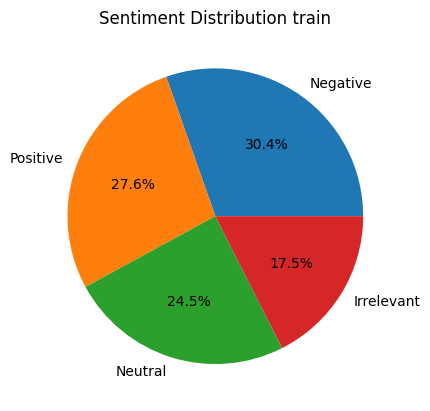

In [27]:
get_distribution_sentiment(train, "train")

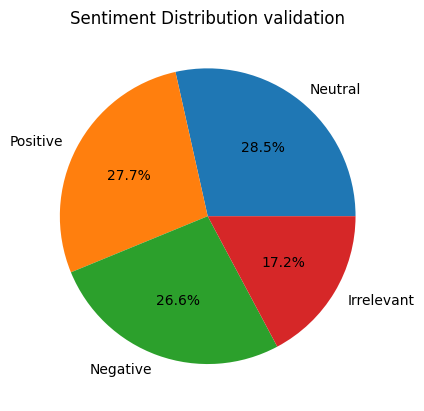

In [28]:
get_distribution_sentiment(validation, "validation")

### <b><span style='color:#F1A425'>Cleaning the text</span></b>

In [29]:
def draw_word_cloud(data, label):
    word_cloud_text = ''.join(data[data["Sentiment"]==label].Tweet_content)
    wordcloud = WordCloud(
        max_font_size=100,
        max_words=100,
        background_color="black",
        scale=10,
        width=800,
        height=800
    ).generate(word_cloud_text)
    #Figure properties
    plt.figure(figsize=(6,6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [30]:
# draw_word_cloud(train, "Positive")

In [31]:
# draw_word_cloud(train, "Negative")

In [32]:
# draw_word_cloud(validation, "Positive")

In [33]:
# draw_word_cloud(validation, "Negative")

### <b><span style='color:#F1A425'>Cleaning the text</span></b>

In [34]:
##CUSTOM DEFINED FUNCTIONS TO CLEAN THE TWEETS

nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))
nltk.download('wordnet')

#Clean emojis from text
def strip_emoji(text):
    emoji_pattern = emoji.demojize(text)
    return re.sub(r":[a-zA-Z_]+:", "", emoji_pattern)

#Remove punctuations, links, mentions and \r\n new line characters
def strip_all_entities(text):
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    without_sw = [word for word in word_tokenize(new_tweet2) if word.lower() not in stop_words]
    # Lemmatize
    text_len = [WordNetLemmatizer().lemmatize(t) for t in without_sw]
    # Stem
    text_cleaned = [PorterStemmer().stem(w) for w in text_len]
    new_tweet3 = " ".join(text_cleaned)
    return new_tweet3

#Filter special characters such as & and $ present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

def remove_mult_spaces(text): # remove multiple spaces
    return re.sub("\s\s+" , " ", text)

def clean_text(t):
    return remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t)))))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [35]:
texts_new = []
for t in train.Tweet_content:
    texts_new.append(clean_text(t))
train['cleaned_tweet'] = [text.lower() for text in texts_new]

In [36]:
texts_new = []
for t in validation.Tweet_content:
    texts_new.append(clean_text(t))
validation['cleaned_tweet'] = texts_new

In [37]:
texts_new = []
for t in out_sample.Sentence:
    texts_new.append(clean_text(t))
out_sample['cleaned_tweet'] = [text.lower() for text in texts_new]

### <b><span style='color:#F1A425'>Checking for tweets less than 1 words after cleaning</span></b>

In [38]:
def add_len_cleaned(df):
    text_len = []
    for text in df.cleaned_tweet:
        tweet_len = len(text.split())
        text_len.append(tweet_len)
    df['text_len'] = text_len
    return df

In [39]:
train = add_len_cleaned(train).copy()

In [40]:
validation = add_len_cleaned(validation).copy()

In [41]:
def plot_tweets(df, words = 10):
    plt.figure(figsize=(7,5))
    ax = sns.countplot(x='text_len', data=df[df['text_len']<10], palette='mako')
    plt.title('Training tweets with less than 10 words')
    plt.yticks([])
    ax.bar_label(ax.containers[0])
    plt.ylabel('count')
    plt.xlabel('')
    plt.show()

In [42]:
import seaborn as sns

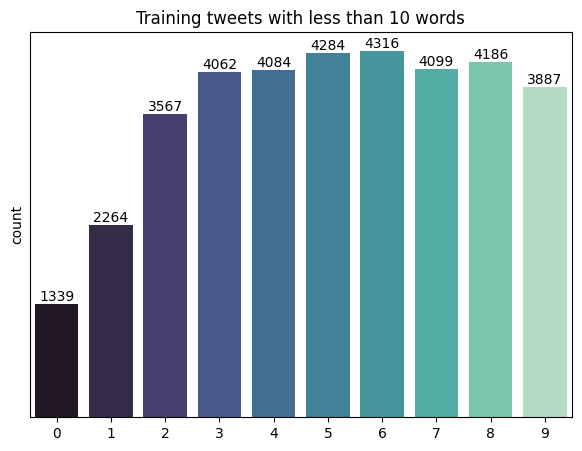

In [43]:
plot_tweets(train)

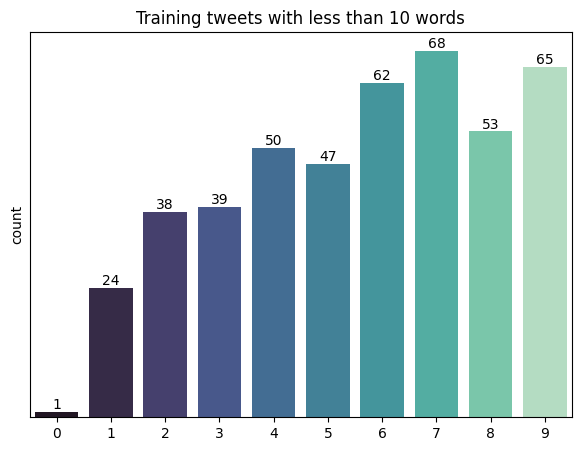

In [44]:
plot_tweets(validation)

In [45]:
train.shape

(70958, 6)

In [46]:
validation.shape

(1000, 6)

In [47]:
train = train[train['text_len'] > 4]
train.shape

(55642, 6)

In [48]:
validation = validation[validation['text_len'] > 4]
validation.shape

(848, 6)

In [49]:
train_shuffled = train.sample(frac=1, random_state=42)  # Set a random_state for reproducibility
n_train_samples = int(len(train) * 0.8)

# Split the DataFrame into training and test sets
train = train_shuffled.iloc[:n_train_samples]
test = train_shuffled.iloc[n_train_samples:]

# Optional: Reset the DataFrame index
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [50]:
train.shape

(44513, 6)

In [51]:
test.shape

(11129, 6)

In [52]:
train.head(10)

,Tweet_ID,Entity,Sentiment,Tweet_content,cleaned_tweet,text_len
0,1580,Battlefield,Neutral,Lunge mine is Jungle carabin + mate = The funn...,lung mine jungl carabin mate funniest solut xd...,10
1,13193,Xbox(Xseries),Negative,x box won't catch me till they change this con...,x box wont catch till chang contract,7
2,7873,MaddenNFL,Negative,@ EAMaddenNFL Ask how a 91ovr team that is sup...,eamaddennfl ask 91ovr team suppos compet 99ovr...,27
3,9915,PlayStation5(PS5),Neutral,"Facts, bitch who can ’ t even get that ps5. Wa...",fact bitch even get ps5 wait lol,7
4,8264,Microsoft,Positive,@ Ronnie2K but that's fine I don't think @ mic...,ronnie2k that fine dont think microsoft xboxsu...,11
5,2276,CallOfDuty,Irrelevant,. Florida family says a Philadelphia police of...,florida famili say philadelphia polic offic we...,18
6,6356,FIFA,Irrelevant,Shame @ weemanronza should have got me in the ...,shame weemanronza got first round fifa tournam...,13
7,3225,Facebook,Neutral,Discover our amazing children's products at da...,discov amaz children product darlyngandcocom p...,12
8,3104,Dota2,Irrelevant,"HAHAHA "" 100 % is TI a winrate "".. but That'i ...",hahaha 100 ti winrat thati great test stat rig...,10
9,3272,Facebook,Positive,Facebook showed me this picture from 3 years a...,facebook show pictur 3 year ago one red backpa...,25


In [53]:
# Label encoding sentiments

lb = preprocessing.LabelEncoder()
train["Sentiment"] = lb.fit_transform(train["Sentiment"])
validation["Sentiment"] = lb.fit_transform(validation["Sentiment"])
test["Sentiment"] = lb.fit_transform(test["Sentiment"])
out_sample["Sentiment"] = lb.fit_transform(out_sample["Sentiment"])

<ipython-input-53-df84299c4c78>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["Sentiment"] = lb.fit_transform(train["Sentiment"])
<ipython-input-53-df84299c4c78>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["Sentiment"] = lb.fit_transform(test["Sentiment"])


In [54]:
# Checking labels
lb.classes_

array(['Irrelevant', 'Negative', 'Neutral', 'Positive', 'Sentiment'],
      dtype=object)

In [55]:
train.head(10)

,Tweet_ID,Entity,Sentiment,Tweet_content,cleaned_tweet,text_len
0,1580,Battlefield,2,Lunge mine is Jungle carabin + mate = The funn...,lung mine jungl carabin mate funniest solut xd...,10
1,13193,Xbox(Xseries),1,x box won't catch me till they change this con...,x box wont catch till chang contract,7
2,7873,MaddenNFL,1,@ EAMaddenNFL Ask how a 91ovr team that is sup...,eamaddennfl ask 91ovr team suppos compet 99ovr...,27
3,9915,PlayStation5(PS5),2,"Facts, bitch who can ’ t even get that ps5. Wa...",fact bitch even get ps5 wait lol,7
4,8264,Microsoft,3,@ Ronnie2K but that's fine I don't think @ mic...,ronnie2k that fine dont think microsoft xboxsu...,11
5,2276,CallOfDuty,0,. Florida family says a Philadelphia police of...,florida famili say philadelphia polic offic we...,18
6,6356,FIFA,0,Shame @ weemanronza should have got me in the ...,shame weemanronza got first round fifa tournam...,13
7,3225,Facebook,2,Discover our amazing children's products at da...,discov amaz children product darlyngandcocom p...,12
8,3104,Dota2,0,"HAHAHA "" 100 % is TI a winrate "".. but That'i ...",hahaha 100 ti winrat thati great test stat rig...,10
9,3272,Facebook,3,Facebook showed me this picture from 3 years a...,facebook show pictur 3 year ago one red backpa...,25


In [56]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer
cores

2

In [57]:


#Seperate dependent and independent features
X=train.loc[:,train.columns!='Sentiment']
y=train['Sentiment']
X_valid=validation.loc[:,train.columns!='Sentiment']
y_valid=validation['Sentiment']
from sklearn.model_selection import train_test_split
# Break off validation set from training data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=0)
# summarize
print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)
print('Validation',X_valid.shape,y_valid.shape)


Train (31159, 5) (31159,)
Test (13354, 5) (13354,)
Validation (848, 5) (848,)


In [58]:
# TF IDF Experiment
#TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer #feature extraction
vectorizer = TfidfVectorizer(stop_words='english',ngram_range=(1,3),min_df=10,max_features=10000)

#Train on train data
features_train= vectorizer.fit_transform(X_train['cleaned_tweet'])
#Apply on test data
features_test= vectorizer.transform(X_test['cleaned_tweet'])
# Validation
features_validation = vectorizer.transform(X_valid['cleaned_tweet'])
# Out of Sample
features_out_sample = vectorizer.transform(out_sample['cleaned_tweet'])

In [59]:
#Function to fit and apply a model

Training Random Forest Classifier with the default parameters without hyper parameter tuning

/usr/local/lib/python3.10/dist-packages/yellowbrick/classifier/prcurve.py:254: YellowbrickWarning: micro=True is ignored;specify per_class=False to draw a PR curve after micro-averaging
  warnings.warn(


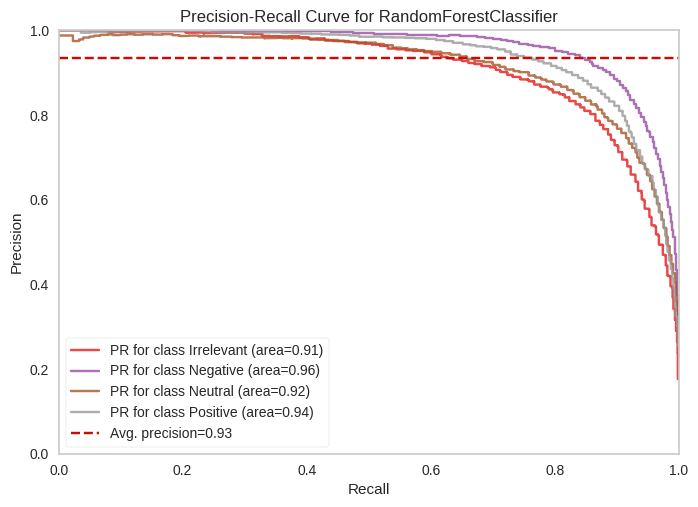

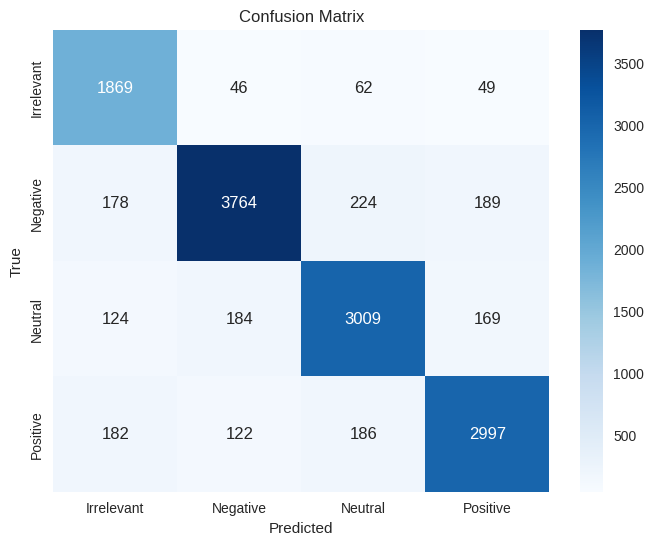


Training report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5526
           1       1.00      1.00      1.00      9480
           2       1.00      1.00      1.00      8213
           3       1.00      1.00      1.00      7940

    accuracy                           1.00     31159
   macro avg       1.00      1.00      1.00     31159
weighted avg       1.00      1.00      1.00     31159

Testing report
              precision    recall  f1-score   support

           0       0.92      0.79      0.85      2353
           1       0.86      0.91      0.89      4116
           2       0.86      0.86      0.86      3481
           3       0.86      0.88      0.87      3404

    accuracy                           0.87     13354
   macro avg       0.88      0.86      0.87     13354
weighted avg       0.87      0.87      0.87     13354

Validation report
              precision    recall  f1-score   support

           0       0.95  

In [ ]:
#Random Forest
rfc=RandomForestClassifier(random_state=101,n_jobs=-1)
rf_fitted=rfc.fit(features_train,y_train)  #fitting the model using training data
pred_test=rfc.predict(features_test)         #using the trained model for prediction on testing data
pred_train = rfc.predict(features_train)      #using the trained model for prediction on training data
pred_valid = rfc.predict(features_validation)   #using the trained model for prediction on validation data

#Visualizing Precision-recall curve to assess the performance of the model
viz = PrecisionRecallCurve(rf_fitted,
                      classes=lb.classes_,
                      per_class=True,
                      cmap="Set1")
viz.fit(features_train,y_train)
viz.score(features_test, y_test)
viz.show();

viz.show()

#Plotting confusion matrix to identify
conf_matrix = confusion_matrix(pred_test,y_test)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=lb.classes_, yticklabels=lb.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print()
print('Training report')
print(classification_report(y_train,pred_train))
print('Testing report')
print(classification_report(y_test,pred_test))
print('Validation report')
print(classification_report(y_valid,pred_valid))

Trying for 10 different configurations of hyperparameters for the random forest classifier

In [ ]:
configurations = [
    {"max_depth": 10, "max_features": "auto", "n_estimators": 100},
    {"max_depth": 20, "max_features": "auto", "n_estimators": 200},
    {"max_depth": 30, "max_features": "sqrt", "n_estimators": 300},
    {"max_depth": 50, "max_features": "log2", "n_estimators": 400},
    {"max_depth": 5, "max_features": "sqrt", "n_estimators": 150},
    {"max_depth": 15, "max_features": "log2", "n_estimators": 250},
    {"max_depth": 25, "max_features": "auto", "n_estimators": 350},
    {"max_depth": 40, "max_features": "sqrt", "n_estimators": 450},
    {"max_depth": 8, "max_features": "auto", "n_estimators": 120},
    {"max_depth": 18, "max_features": "log2", "n_estimators": 220}
]

# Loop through different configurations
for i, config in enumerate(configurations):
    print(f"Configuration {i + 1}")

    # Create and train the model
    rfc = RandomForestClassifier(
        max_depth=config["max_depth"],
        max_features=config["max_features"],
        n_estimators=config["n_estimators"],
        random_state=101,
        n_jobs=-1
    )
    rfc.fit(features_train, y_train)

    # Predictions
    pred_train = rfc.predict(features_train)
    pred_test = rfc.predict(features_test)
    pred_valid = rfc.predict(features_validation)

    # Evaluate and print classification reports
    print("Training report")
    print(classification_report(y_train, pred_train))
    print("Testing report")
    print(classification_report(y_test, pred_test))
    print("Validation report")
    print(classification_report(y_valid, pred_valid))
    print("=" * 80)

Configuration 1


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Training report
              precision    recall  f1-score   support

           0       0.99      0.05      0.09      5526
           1       0.37      0.96      0.54      9480
           2       0.77      0.22      0.34      8213
           3       0.67      0.34      0.45      7940

    accuracy                           0.44     31159
   macro avg       0.70      0.39      0.35     31159
weighted avg       0.66      0.44      0.38     31159

Testing report
              precision    recall  f1-score   support

           0       0.99      0.05      0.09      2353
           1       0.37      0.95      0.53      4116
           2       0.71      0.20      0.31      3481
           3       0.61      0.32      0.42      3404

    accuracy                           0.43     13354
   macro avg       0.67      0.38      0.34     13354
weighted avg       0.63      0.43      0.37     13354

Validation report
              precision    recall  f1-score   support

           0       1.00   

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Training report
              precision    recall  f1-score   support

           0       0.99      0.07      0.14      5526
           1       0.46      0.94      0.62      9480
           2       0.79      0.43      0.56      8213
           3       0.67      0.59      0.63      7940

    accuracy                           0.56     31159
   macro avg       0.73      0.51      0.49     31159
weighted avg       0.70      0.56      0.52     31159

Testing report
              precision    recall  f1-score   support

           0       0.99      0.06      0.11      2353
           1       0.45      0.90      0.60      4116
           2       0.70      0.35      0.47      3481
           3       0.59      0.54      0.57      3404

    accuracy                           0.52     13354
   macro avg       0.68      0.46      0.44     13354
weighted avg       0.65      0.52      0.47     13354

Validation report
              precision    recall  f1-score   support

           0       1.00   

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Training report
              precision    recall  f1-score   support

           0       0.99      0.12      0.22      5526
           1       0.50      0.95      0.66      9480
           2       0.82      0.52      0.63      8213
           3       0.71      0.65      0.68      7940

    accuracy                           0.61     31159
   macro avg       0.75      0.56      0.55     31159
weighted avg       0.72      0.61      0.58     31159

Testing report
              precision    recall  f1-score   support

           0       0.96      0.08      0.16      2353
           1       0.47      0.90      0.62      4116
           2       0.71      0.42      0.53      3481
           3       0.61      0.59      0.60      3404

    accuracy                           0.55     13354
   macro avg       0.69      0.50      0.48     13354
weighted avg       0.66      0.55      0.51     13354

Validation report
              precision    recall  f1-score   support

           0       1.00   

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Training report
              precision    recall  f1-score   support

           0       1.00      0.04      0.08      5526
           1       0.35      0.97      0.51      9480
           2       0.75      0.18      0.29      8213
           3       0.69      0.24      0.35      7940

    accuracy                           0.41     31159
   macro avg       0.70      0.36      0.31     31159
weighted avg       0.66      0.41      0.34     31159

Testing report
              precision    recall  f1-score   support

           0       1.00      0.04      0.08      2353
           1       0.35      0.96      0.51      4116
           2       0.70      0.16      0.26      3481
           3       0.63      0.23      0.33      3404

    accuracy                           0.40     13354
   macro avg       0.67      0.35      0.30     13354
weighted avg       0.63      0.40      0.33     13354

Validation report
              precision    recall  f1-score   support

           0       1.00   

# Grid search to find best parameters

By controlling the parameters of the random forest classifier such as 'max-depth', 'max_features', 'n_estimators' help us limit overfitting. We have utilized GridSearchCV here to find the best optimal parameters

In [ ]:
# Setting Parameters for grid search
param_grid = {"max_depth": [2,10,20,50, 80],
            "max_features": ["auto", "sqrt", "log2"],
            "n_estimators":[100,200,500,600,800]
}

In [ ]:
# Grid search for optimal parameters
grid_search = GridSearchCV(rfc, param_grid, cv=5, n_jobs=-1,verbose=4)
best_model = None

grid_search.fit(features_train,y_train)

Fitting 5 folds for each of 75 candidates, totalling 375 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_depth=18, max_features='log2',
                                              n_estimators=220, n_jobs=-1,
                                              random_state=101),
             n_jobs=-1,
             param_grid={'max_depth': [2, 10, 20, 50, 80],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 200, 500, 600, 800]},
             verbose=4)

In [ ]:
grid_search.best_params_  # the best parameters are obtained from the GridSearch

{'max_depth': 80, 'max_features': 'auto', 'n_estimators': 800}

# Performing the RandomForestClassifier with the best parameters achieved

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/yellowbrick/classifier/prcurve.py:254: YellowbrickWarning: micro=True is ignored;specify per_class=False to draw a PR curve after micro-averaging
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_feat

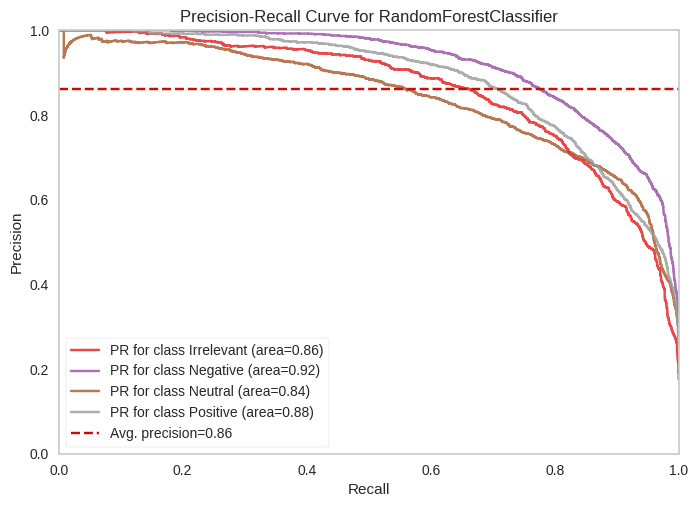

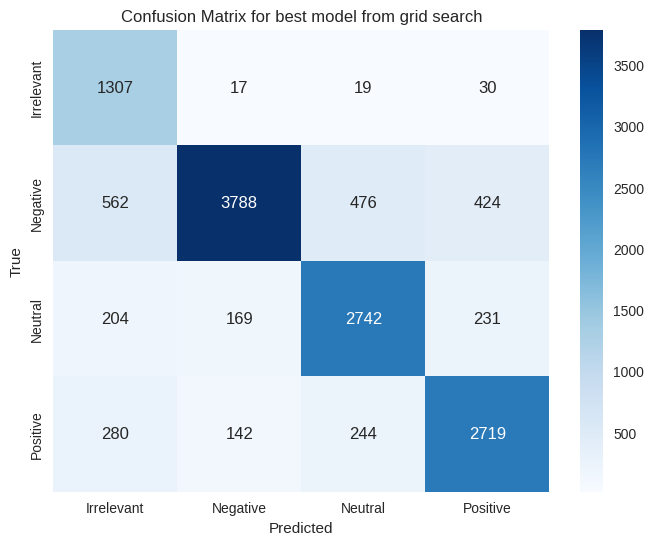


Training report
              precision    recall  f1-score   support

           0       1.00      0.82      0.90      5526
           1       0.87      0.99      0.92      9480
           2       0.96      0.95      0.96      8213
           3       0.97      0.93      0.95      7940

    accuracy                           0.93     31159
   macro avg       0.95      0.92      0.93     31159
weighted avg       0.94      0.93      0.93     31159

Testing report
              precision    recall  f1-score   support

           0       0.95      0.56      0.70      2353
           1       0.72      0.92      0.81      4116
           2       0.82      0.79      0.80      3481
           3       0.80      0.80      0.80      3404

    accuracy                           0.79     13354
   macro avg       0.82      0.77      0.78     13354
weighted avg       0.81      0.79      0.79     13354

Validation report
              precision    recall  f1-score   support

           0       0.95  

In [ ]:
#{'max_depth': 80, 'max_features': 'auto', 'n_estimators': 800} -> best parameters
rfc = RandomForestClassifier(max_depth = 80,
                                 max_features = 'auto',
                                 n_estimators = 800,
                             n_jobs=-1)
# rfc=RandomForestClassifier(random_state=101,n_jobs=-1)
rf_fitted=rfc.fit(features_train,y_train)
pred_test=rfc.predict(features_test)
pred_train = rfc.predict(features_train)
pred_valid = rfc.predict(features_validation)

#train the model, Fitting twice unable to figure out how to reuse the fitted model
viz = PrecisionRecallCurve(rf_fitted,
                      classes=lb.classes_,
                      per_class=True,
                      cmap="Set1")
viz.fit(features_train,y_train)
viz.score(features_test, y_test)
viz.show();

viz.show()

conf_matrix = confusion_matrix(pred_test,y_test)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=lb.classes_, yticklabels=lb.classes_)
plt.title("Confusion Matrix for best model from grid search")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print()
print('Training report')
print(classification_report(y_train,pred_train))
print('Testing report')
print(classification_report(y_test,pred_test))
print('Validation report')
print(classification_report(y_valid,pred_valid))

We have visualized the precision-recall curve and confusion matrix to evaluate overfitting and underfitting. It is observed that with

#Out of Sample Validation

In [60]:
out_sample.head(10)

,Sentence,Sentiment,cleaned_tweet
0,Sentence,4,sentenc
1,The GeoSolutions technology will leverage Bene...,3,geosolut technolog leverag benefon gp solut pr...
2,"$ESI on lows, down $1.50 to $2.50 BK a real po...",1,esi low 150 250 bk real possibl
3,"For the last quarter of 2010 , Componenta 's n...",3,last quarter 2010 componenta net sale doubl eu...
4,According to the Finnish-Russian Chamber of Co...,0,accord finnishrussian chamber commerc major co...
5,The Swedish buyout firm has sold its remaining...,2,swedish buyout firm sold remain 224 percent st...
6,$SPY wouldn't be surprised to see a green close,3,spi wouldnt surpris see green close
7,Shell's $70 Billion BG Deal Meets Shareholder ...,1,shell 70 billion bg deal meet sharehold skeptic
8,SSH COMMUNICATIONS SECURITY CORP STOCK EXCHANG...,1,ssh commun secur corp stock exchang releas oct...
9,Kone 's net sales rose by some 14 % year-on-ye...,3,kone net sale rose 14 yearonyear first nine mo...


In [61]:
out_sample.Sentiment.value_counts()

3    1852
0    1752
2    1378
1     860
4       1
Name: Sentiment, dtype: int64

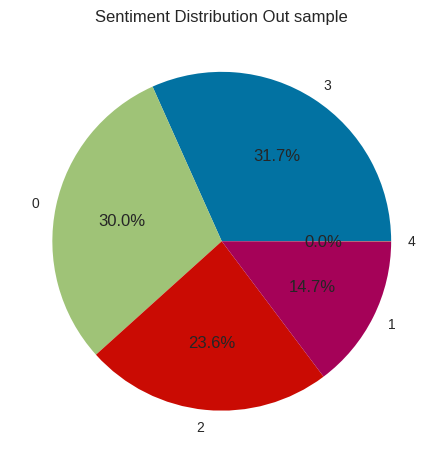

In [62]:
get_distribution_sentiment(out_sample,'Out sample')

In [63]:
rfc = RandomForestClassifier(max_depth = 80,
                                 max_features = 'auto',
                                 n_estimators = 800,
                             n_jobs=-1)

rf_fitted = rfc.fit(features_train,y_train)
pred_out_sample = rfc.predict(features_out_sample)
print("Out of sample")
print(classification_report(out_sample["Sentiment"], pred_out_sample))

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Out of sample
              precision    recall  f1-score   support

           0       0.51      0.01      0.02      1752
           1       0.14      0.66      0.23       860
           2       0.22      0.26      0.23      1378
           3       0.57      0.06      0.11      1852
           4       0.00      0.00      0.00         1

    accuracy                           0.18      5843
   macro avg       0.29      0.20      0.12      5843
weighted avg       0.41      0.18      0.13      5843



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##**Conclusion:**



*   #### With the optimal parameters obtained, the Random Forest model has performed well on the validation data with an accuracy of 0.87, F1-score of 0.87, Precision of 0.88 and Recall of 0.86
*   #### Random Forest is highly dependent on the features that we have trained on, so for the out of sample dataset we need an algorithm like Neural nets which has more exhaustive features and is more adpatable to the patterns behind the data


*   #### Random Forest can capture the interactions between features, and from our analysis we infer that the algorithm can provide good results for sentiment analysis tasks that don't heavily rely on language nuances






